# **Modelo de predicción de ventas**
> Mariana Castro Payns A01706038

> Maria de los Angeles Arista Huerta A01369984

> Marcela Ibarra Mora A01231973

*Competencia en Kaggle:
Store Sales - Time Series Forecasting*

Realizar la predicción de ventas en determinadas tiendas con datos  proporcionados por "Corporación Favorita".
La predicción deseada es  para los próximos 16 días, de la última fecha:
 '15-08-2017'

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.linear_model import LinearRegression

# pandas dataframe configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## **Data Cleaning**

We will be applying the ETL technique for data cleaning of several data sets that will help make a forecast prediction of sales. 

### *Cleaning the Train Dataset*

The fist data set will be the Train Dataset. 

Foremost we load the corresponding cvs and print a preview of said data. 

In [2]:
df_train = pd.read_csv('train.csv')
df_train

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE    0.0000   
1              1  2013-01-01          1                   BABY CARE    0.0000   
2              2  2013-01-01          1                      BEAUTY    0.0000   
3              3  2013-01-01          1                   BEVERAGES    0.0000   
4              4  2013-01-01          1                       BOOKS    0.0000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY  438.1330   
3000884  3000884  2017-08-15          9              PREPARED FOODS  154.5530   
3000885  3000885  2017-08-15          9                     PRODUCE 2419.7290   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.0000   
3000887  3000887  2017-08-15          9                     SEAFOOD   16.0000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

Then we get the main info of the dataset to get each column along its data type. 
We can see columns like id, date, store number, family, sales and on promotion.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


Then we look for NaN values in the dataset. 

In [4]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Since the table above shows a count of 0 NaN values we dont need to transform any of the columns.

We decided to drop the "id" column because we consider it to be irrelevant since pandas gives a default "id".

In [5]:
df_train = df_train.drop(['id'],axis=1)

In [6]:
df_train["date"] = pd.to_datetime(df_train.date)

In [7]:
df_train.describe()

store_nbr        sales  onpromotion
count 3000888.0000 3000888.0000 3000888.0000
mean       27.5000     357.7757       2.6028
std        15.5858    1101.9977      12.2189
min         1.0000       0.0000       0.0000
25%        14.0000       0.0000       0.0000
50%        27.5000      11.0000       0.0000
75%        41.0000     195.8473       0.0000
max        54.0000  124717.0000     741.0000

In [8]:
df_train_date = df_train.groupby('date').sum()['sales']
df_train_date.min()

2511.6189990000003

<AxesSubplot:ylabel='Frequency'>

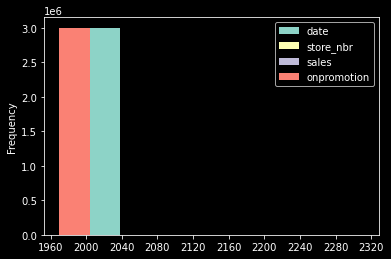

In [9]:
df_train.plot.hist(by='sales')

<AxesSubplot:xlabel='date'>

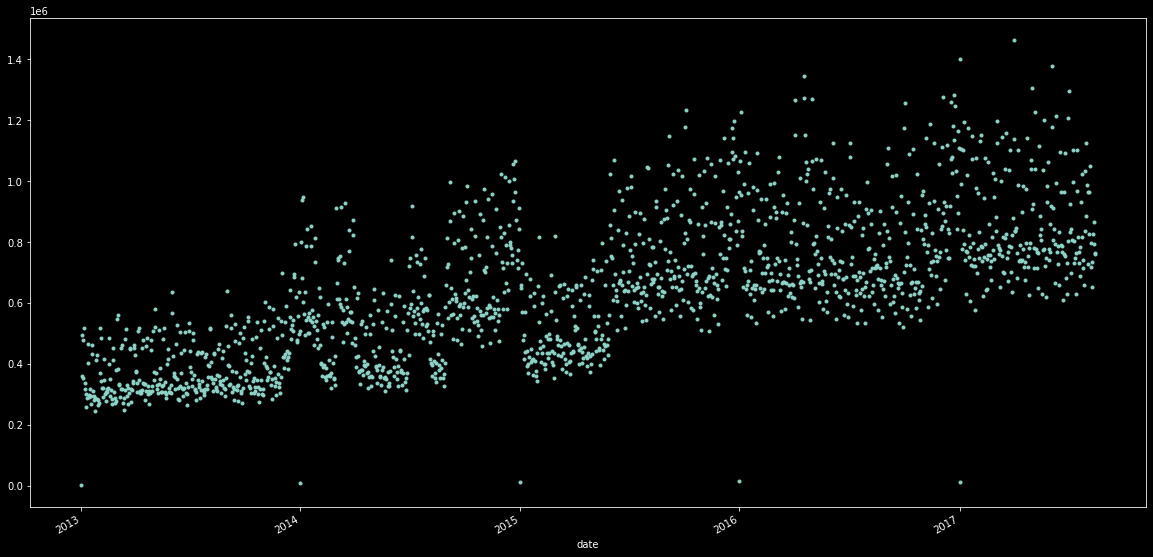

In [10]:
df_train_date.plot(style='.',figsize = (20, 10))

array([[<AxesSubplot:xlabel='store_nbr', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='sales', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='onpromotion', ylabel='store_nbr'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='sales'>,
        <AxesSubplot:xlabel='sales', ylabel='sales'>,
        <AxesSubplot:xlabel='onpromotion', ylabel='sales'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='onpromotion'>,
        <AxesSubplot:xlabel='sales', ylabel='onpromotion'>,
        <AxesSubplot:xlabel='onpromotion', ylabel='onpromotion'>]],
      dtype=object)

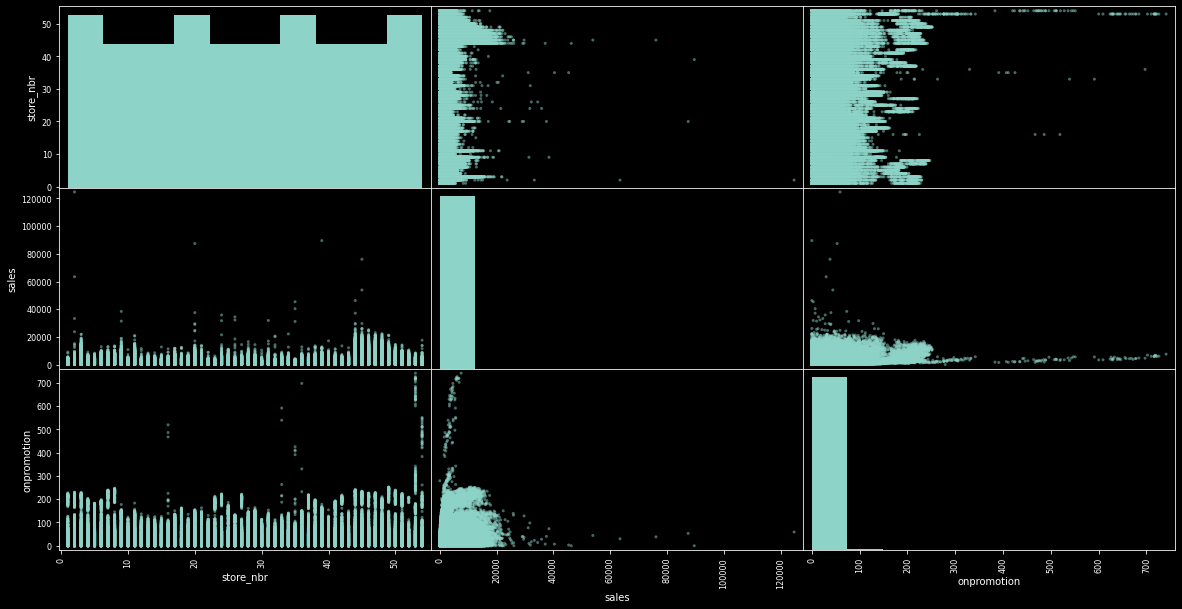

In [11]:
pd.plotting.scatter_matrix(df_train,figsize = (20, 10))

### *Cleaning the Transactions Dataset*

Now we move to the next dataset being Transactions. 

In [12]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

The next step will be getting the main info of said data frame to see the number and name of columns, and the data type. We get columns like date, store number and transactions.

In [13]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


Then we check for NaN values in the whole dataset

In [14]:
df_transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

The result shows a sum of 0 NaN values so there is no need to make a data tranformation for this dataset. 

For visualization porpuses we decided to sort the "store_nbr" column. 

In [15]:
df_transactions.sort_values(by=['store_nbr'])

date  store_nbr  transactions
42968  2015-07-03          1          2012
11033  2013-08-28          1          1831
81328  2017-07-07          1          1843
73300  2017-02-07          1          1887
2347   2013-02-22          1          1805
...           ...        ...           ...
50112  2015-11-17         54           744
78033  2017-05-06         54           840
17002  2014-01-03         54           798
20949  2014-03-28         54           839
83487  2017-08-15         54           802

[83488 rows x 3 columns]

In [16]:
df_transactions["date"] = pd.to_datetime(df_transactions.date)
df_transactions_date = df_transactions.groupby('date').sum()['transactions']

<AxesSubplot:xlabel='date'>

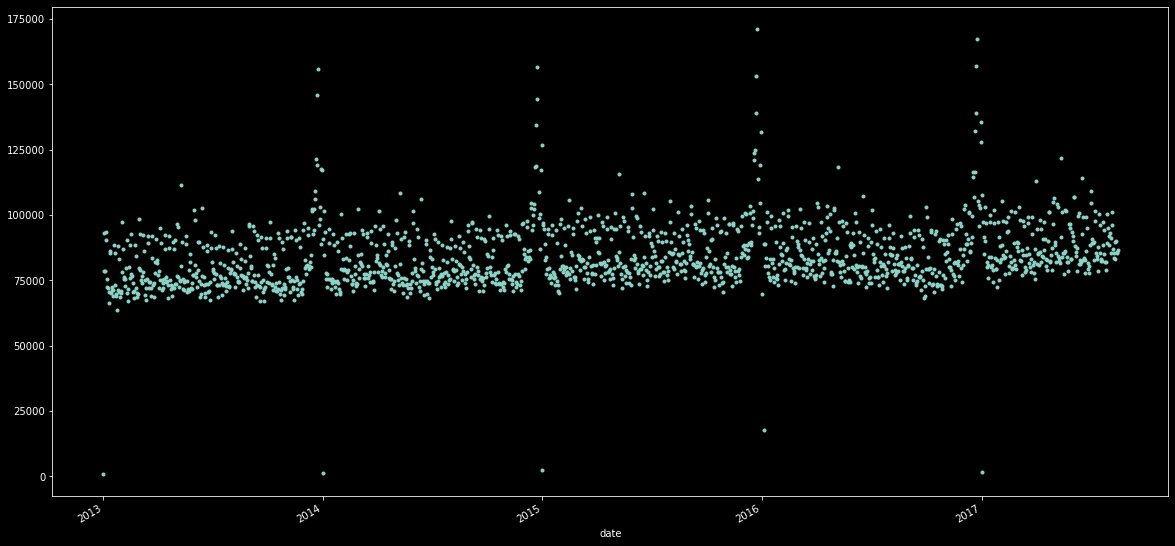

In [17]:
df_transactions_date.plot(style='.',figsize = (20, 10))

array([[<AxesSubplot:xlabel='store_nbr', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='transactions', ylabel='store_nbr'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='transactions'>,
        <AxesSubplot:xlabel='transactions', ylabel='transactions'>]],
      dtype=object)

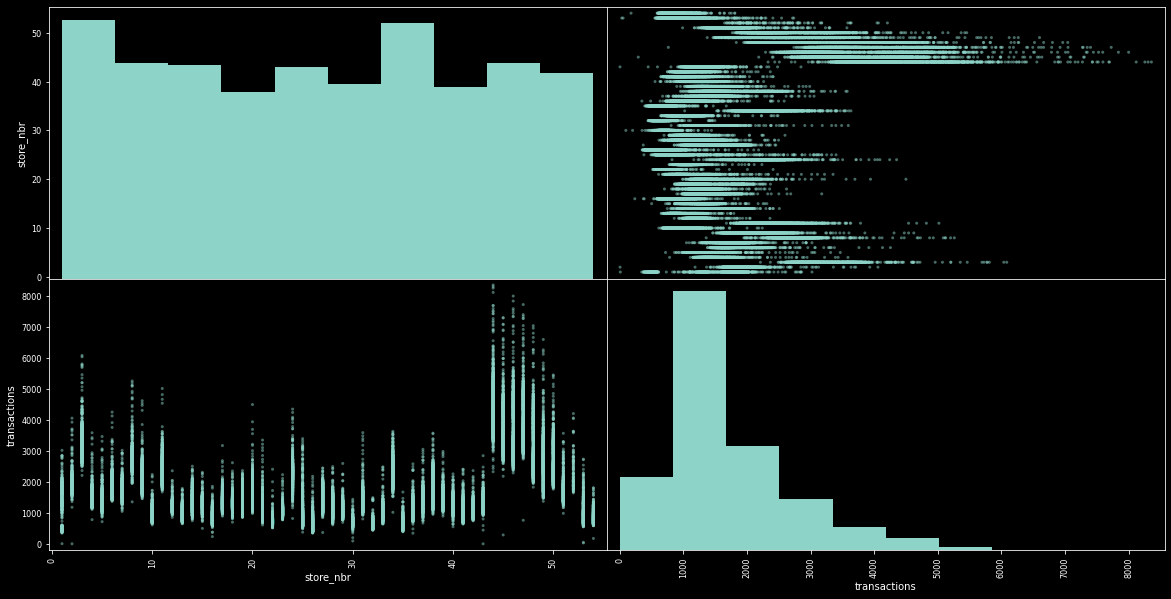

In [18]:
pd.plotting.scatter_matrix(df_transactions,figsize = (20, 10))

### *Cleaning the Stores Dataset*

Now we move onto the next dataset which is Stores.

In [19]:
df_stores = pd.read_csv('stores.csv')
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

The next step will be verifing the main dataset info to obtain number of columns, name and data type of each of the columns. From this data set we have columns like store number, city, state, type, cluster. 

In [20]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


Then its necessary to check for NaN values in the Dataset for each column. 

In [21]:
df_stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

There is no need to make transformation of data because the sum of NaN values was 0.

In [22]:
df_stores = df_stores.drop(['state'],axis=1)

In [23]:
df_stores.head()

store_nbr           city type  cluster
0          1          Quito    D       13
1          2          Quito    D       13
2          3          Quito    D        8
3          4          Quito    D        9
4          5  Santo Domingo    D        4

In [24]:
df_stores['type'].replace({'A':1,'B':2,'C':3,'D':4,'E':5},inplace=True)

array([[<AxesSubplot:xlabel='store_nbr', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='type', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='cluster', ylabel='store_nbr'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='type'>,
        <AxesSubplot:xlabel='type', ylabel='type'>,
        <AxesSubplot:xlabel='cluster', ylabel='type'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='cluster'>,
        <AxesSubplot:xlabel='type', ylabel='cluster'>,
        <AxesSubplot:xlabel='cluster', ylabel='cluster'>]], dtype=object)

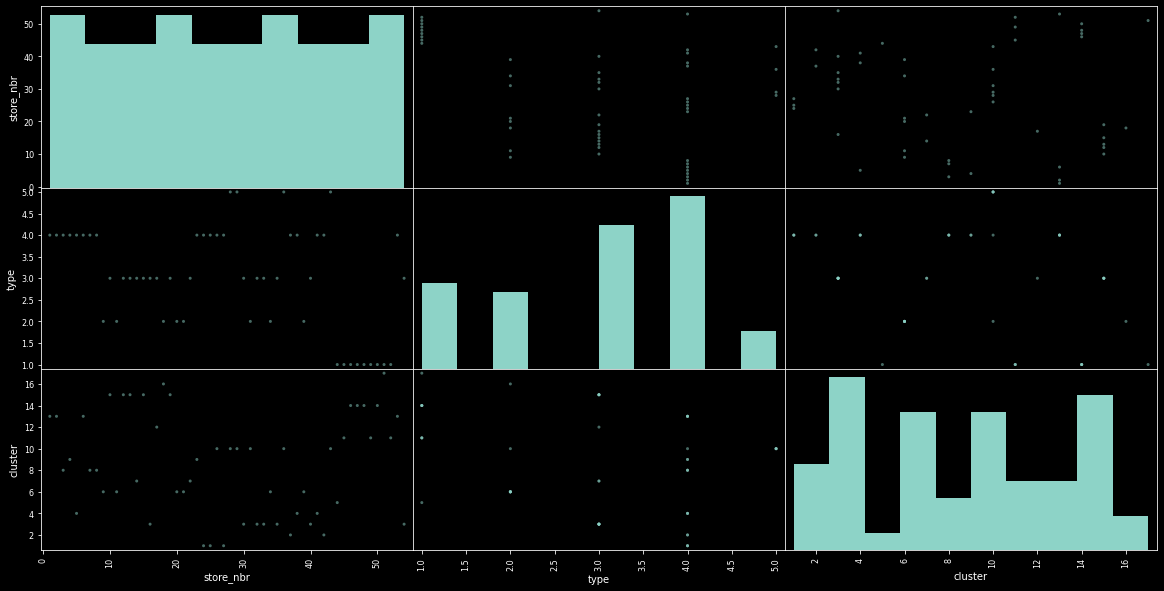

In [25]:
pd.plotting.scatter_matrix(df_stores,figsize = (20, 10))

### *Cleaning the Oil Dataset*

The next Dataset to clean will be the oil data set. 

In [26]:
df_oil = pd.read_csv('oil.csv')
df_oil

date  dcoilwtico
0     2013-01-01         NaN
1     2013-01-02     93.1400
2     2013-01-03     92.9700
3     2013-01-04     93.1200
4     2013-01-07     93.2000
...          ...         ...
1213  2017-08-25     47.6500
1214  2017-08-28     46.4000
1215  2017-08-29     46.4600
1216  2017-08-30     45.9600
1217  2017-08-31     47.2600

[1218 rows x 2 columns]

We get the main info to get the name of the columns and the data type. This dataset contains columns like date and price of oil named as dcoilwtico. 

In [27]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


Then we check for NaN values in the data set columns. 

In [28]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

Since we have several missing data, we decided to make a transformation. We impute the data by obtaining the mean of the column and replace it on the NaN values.

In [29]:
mean = df_oil['dcoilwtico'].mean()
mean

67.71436595744689

In [30]:
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].replace(np.nan, mean)

Once again we check for missing data to confirm the changes made before. Where we get a total of 0 NaN values. 

In [31]:
df_oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [32]:
df_oil

date  dcoilwtico
0     2013-01-01     67.7144
1     2013-01-02     93.1400
2     2013-01-03     92.9700
3     2013-01-04     93.1200
4     2013-01-07     93.2000
...          ...         ...
1213  2017-08-25     47.6500
1214  2017-08-28     46.4000
1215  2017-08-29     46.4600
1216  2017-08-30     45.9600
1217  2017-08-31     47.2600

[1218 rows x 2 columns]

### *Cleaning the Holidays Dataset*

The next Dataset will be holidays. 

Here we only load the corresponding csv file and get the first 60 values to get a preview. 

In [33]:
df_holidays = pd.read_csv('holidays_events.csv')
df_holidays.head(60)

date        type    locale                     locale_name  \
0   2012-03-02     Holiday     Local                           Manta   
1   2012-04-01     Holiday  Regional                        Cotopaxi   
2   2012-04-12     Holiday     Local                          Cuenca   
3   2012-04-14     Holiday     Local                        Libertad   
4   2012-04-21     Holiday     Local                        Riobamba   
5   2012-05-12     Holiday     Local                            Puyo   
6   2012-06-23     Holiday     Local                        Guaranda   
7   2012-06-25     Holiday  Regional                        Imbabura   
8   2012-06-25     Holiday     Local                       Latacunga   
9   2012-06-25     Holiday     Local                         Machala   
10  2012-07-03     Holiday     Local                   Santo Domingo   
11  2012-07-03     Holiday     Local                       El Carmen   
12  2012-07-23     Holiday     Local                         Cayambe   
13  2012-08-05     Holiday     Local                      Esmeraldas   
14  2012-08-10     Holiday  National                         Ecuador   
15  2012-08-15     Holiday     Local                        Riobamba   
16  2012-08-24     Holiday     Local                          Ambato   
17  2012-09-28     Holiday     Local                          Ibarra   
18  2012-10-07     Holiday     Local                         Quevedo   
19  2012-10-09     Holiday  National                         Ecuador   
20  2012-10-12    Transfer  National                         Ecuador   
21  2012-11-02     Holiday  National                         Ecuador   
22  2012-11-03     Holiday  National                         Ecuador   
23  2012-11-06     Holiday  Regional  Santo Domingo de los Tsachilas   
24  2012-11-07     Holiday  Regional                     Santa Elena   
25  2012-11-10     Holiday     Local                        Guaranda   
26  2012-11-11     Holiday     Local                       Latacunga   
27  2012-11-12     Holiday     Local                          Ambato   
28  2012-12-05  Additional     Local                           Quito   
29  2012-12-06     Holiday     Local                           Quito   
30  2012-12-08     Holiday     Local                            Loja   
31  2012-12-21  Additional  National                         Ecuador   
32  2012-12-22     Holiday     Local                         Salinas   
33  2012-12-22  Additional  National                         Ecuador   
34  2012-12-23  Additional  National                         Ecuador   
35  2012-12-24      Bridge  National                         Ecuador   
36  2012-12-24  Additional  National                         Ecuador   
37  2012-12-25     Holiday  National                         Ecuador   
38  2012-12-26  Additional  National                         Ecuador   
39  2012-12-31      Bridge  National                         Ecuador   
40  2012-12-31  Additional  National                         Ecuador   
41  2013-01-01     Holiday  National                         Ecuador   
42  2013-01-05    Work Day  National                         Ecuador   
43  2013-01-12    Work Day  National                         Ecuador   
44  2013-02-11     Holiday  National                         Ecuador   
45  2013-02-12     Holiday  National                         Ecuador   
46  2013-03-02     Holiday     Local                           Manta   
47  2013-04-01     Holiday  Regional                        Cotopaxi   
48  2013-04-12     Holiday     Local                          Cuenca   
49  2013-04-14     Holiday     Local                        Libertad   
50  2013-04-21     Holiday     Local                        Riobamba   
51  2013-04-29     Holiday  National                         Ecuador   
52  2013-05-01     Holiday  National                         Ecuador   
53  2013-05-11  Additional  National                         Ecuador   
54  2013-05-12     Holiday     Local              

We get the main info of the dataset like number of columns, name and data type. With this we can see that the dataset has columns such as date, type, locale, locale name, description and transferred. 

In [34]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


Then we check for NaN values in the dataset. 

In [35]:
df_holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

The count of missing values was 0 so we dont need to make any kind of transformation on the data. 

We decided that the "description" column could be dropped because it has no relevant values for the prediction we are looking to make. 

In [36]:
df_holidays = df_holidays.drop(["description"],axis=1)

Lastly we check if the drop was made correctly. 

In [37]:
df_holidays

date        type    locale locale_name  transferred
0    2012-03-02     Holiday     Local       Manta        False
1    2012-04-01     Holiday  Regional    Cotopaxi        False
2    2012-04-12     Holiday     Local      Cuenca        False
3    2012-04-14     Holiday     Local    Libertad        False
4    2012-04-21     Holiday     Local    Riobamba        False
..          ...         ...       ...         ...          ...
345  2017-12-22  Additional  National     Ecuador        False
346  2017-12-23  Additional  National     Ecuador        False
347  2017-12-24  Additional  National     Ecuador        False
348  2017-12-25     Holiday  National     Ecuador        False
349  2017-12-26  Additional  National     Ecuador        False

[350 rows x 5 columns]

In [38]:
df_train

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE    0.0000   
1       2013-01-01          1                   BABY CARE    0.0000   
2       2013-01-01          1                      BEAUTY    0.0000   
3       2013-01-01          1                   BEVERAGES    0.0000   
4       2013-01-01          1                       BOOKS    0.0000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY  438.1330   
3000884 2017-08-15          9              PREPARED FOODS  154.5530   
3000885 2017-08-15          9                     PRODUCE 2419.7290   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  121.0000   
3000887 2017-08-15          9                     SEAFOOD   16.0000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [39]:
df_train.groupby('date').mean().sales

date
2013-01-01     1.4094
2013-01-02   278.3908
2013-01-03   202.8402
2013-01-04   198.9112
2013-01-05   267.8732
               ...   
2017-08-11   463.7339
2017-08-12   444.7983
2017-08-13   485.7686
2017-08-14   427.0047
2017-08-15   427.9809
Name: sales, Length: 1684, dtype: float64

In [40]:
df_transactions.groupby('date').mean().transactions

date
2013-01-01    770.0000
2013-01-02   2026.4130
2013-01-03   1706.6087
2013-01-04   1706.3913
2013-01-05   2034.1957
                ...   
2017-08-11   1658.3519
2017-08-12   1665.3148
2017-08-13   1592.4630
2017-08-14   1582.3704
2017-08-15   1602.9815
Name: transactions, Length: 1682, dtype: float64

In [41]:
final_data = pd.merge(df_train,df_transactions,on=["date","store_nbr"])

In [42]:
final_data.groupby(["date","store_nbr"]).mean()

sales  onpromotion  transactions
date       store_nbr                                    
2013-01-01 25         76.1097       0.0000      770.0000
2013-01-02 1         224.7621       0.0000     2111.0000
           2         311.1127       0.0000     2358.0000
           3         729.1015       0.0000     3487.0000
           4         309.0935       0.0000     1922.0000
...                       ...          ...           ...
2017-08-15 50        511.4885       4.5455     2804.0000
           51        610.7442       3.8485     1573.0000
           52        563.6378       4.3030     2255.0000
           53        248.7330       3.4545      932.0000
           54        383.8442       6.1818      802.0000

[83488 rows x 3 columns]

In [43]:
df_oil

date  dcoilwtico
0     2013-01-01     67.7144
1     2013-01-02     93.1400
2     2013-01-03     92.9700
3     2013-01-04     93.1200
4     2013-01-07     93.2000
...          ...         ...
1213  2017-08-25     47.6500
1214  2017-08-28     46.4000
1215  2017-08-29     46.4600
1216  2017-08-30     45.9600
1217  2017-08-31     47.2600

[1218 rows x 2 columns]

In [44]:
final_data = pd.concat([final_data,df_oil],ignore_index=True)

In [45]:
final_data

date  store_nbr      family    sales  onpromotion  \
0        2013-01-01 00:00:00    25.0000  AUTOMOTIVE   0.0000       0.0000   
1        2013-01-01 00:00:00    25.0000   BABY CARE   0.0000       0.0000   
2        2013-01-01 00:00:00    25.0000      BEAUTY   2.0000       0.0000   
3        2013-01-01 00:00:00    25.0000   BEVERAGES 810.0000       0.0000   
4        2013-01-01 00:00:00    25.0000       BOOKS   0.0000       0.0000   
...                      ...        ...         ...      ...          ...   
2756317           2017-08-25        NaN         NaN      NaN          NaN   
2756318           2017-08-28        NaN         NaN      NaN          NaN   
2756319           2017-08-29        NaN         NaN      NaN          NaN   
2756320           2017-08-30        NaN         NaN      NaN          NaN   
2756321           2017-08-31        NaN         NaN      NaN          NaN   

         transactions  dcoilwtico  
0            770.0000         NaN  
1            770.0000         NaN  
2            770.0000         NaN  
3            770.0000         NaN  
4            770.0000         NaN  
...               ...         ...  
2756317           NaN     47.6500  
2756318           NaN     46.4000  
2756319           NaN     46.4600  
2756320           NaN     45.9600  
2756321           NaN     47.2600  

[2756322 rows x 7 columns]

On summary, we applied the following:

Verify for NaN values

Convert date datatypes

Group some data

Impute some data

Eliminate some irrevelant data

Also, we decided to use the data from June 2016 to December 2017 to train the models

## **First tries**

For each of the different algorthms we tried using the columns dcoilwtico, transactions and holidays but neither of them really affected the performance of the models, because of this, we only used the average of the sales.

### Linea Regression

In [81]:
df_store_sales = pd.read_csv('train.csv',
                             usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                             dtype = {
                                    'store_nbr': 'category',
                                    'family': 'category',
                                    'sales': 'float32',
                                    'onpromotion': 'uint32',
                                },
                                parse_dates=['date'],
                                infer_datetime_format=True)
df_store_sales['date'] = df_store_sales.date.dt.to_period('D')
df_store_sales = df_store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
df_store_sales = shuffle(df_store_sales)

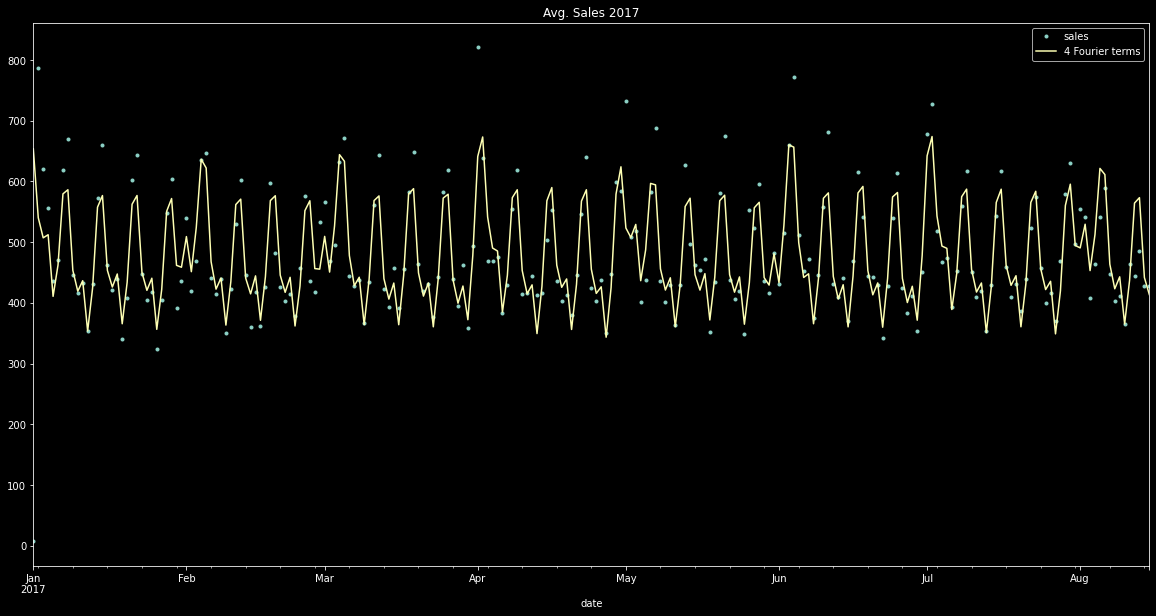

In [82]:
average_sales = df_store_sales.groupby('date').mean().sales
average_sales_2017 = (df_store_sales.groupby('date').mean().sales.squeeze().loc['2017'])
y = average_sales_2017.copy()
fourier_terms = CalendarFourier(freq='M', order = 4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order = 1,
    seasonal = True,
    additional_terms=[fourier_terms],
    drop = True,
)

X = dp.in_sample()
Lineal = LinearRegression().fit(X, y)  #linear model
y1_pred = pd.Series(Lineal.predict(X), index=X.index, 
                    name='4 Fourier Terms')

ax=y.plot(style='.', figsize=(20,10), title="Avg. Sales 2017")
ax=y1_pred.plot(ax=ax, label='4 Fourier terms')
ax.legend();

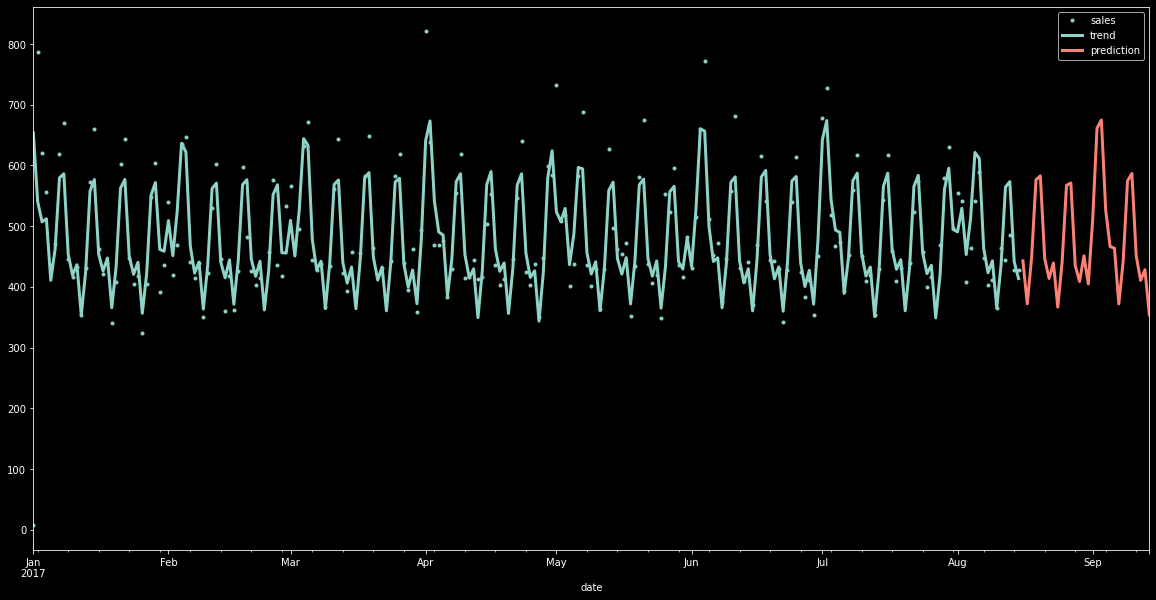

In [83]:
X_forecast = dp.out_of_sample(steps=30)
y_forecast = pd.Series(Lineal.predict(X_forecast),
                      index=X_forecast.index)
ax=average_sales_2017.plot(style='.', figsize=(20,10))
ax=y1_pred.plot(ax=ax, linewidth=3, label='trend', color='C0')
ax=y_forecast.plot(ax=ax, linewidth=3, label='prediction', 
                   color='C3')
ax.legend();

In [91]:
from sklearn.model_selection import cross_val_score

In [92]:
scores = cross_val_score(Lineal, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.19915969 0.76149717 0.69497503 0.83134498 0.68541106]
0.63 accuracy with a standard deviation of 0.22


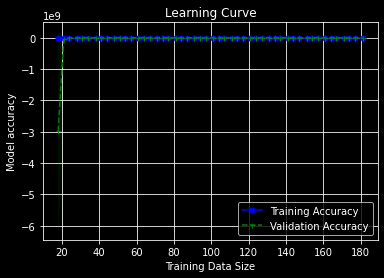

In [85]:
train_sizes, train_scores, test_scores = learning_curve(Lineal, X, y, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

This model didn't had a great performance, beeing underfitting. This means that the model is too simple to predict this data. This problem can be fixed by making the model more complex or transforming the data. 

### Random Forest

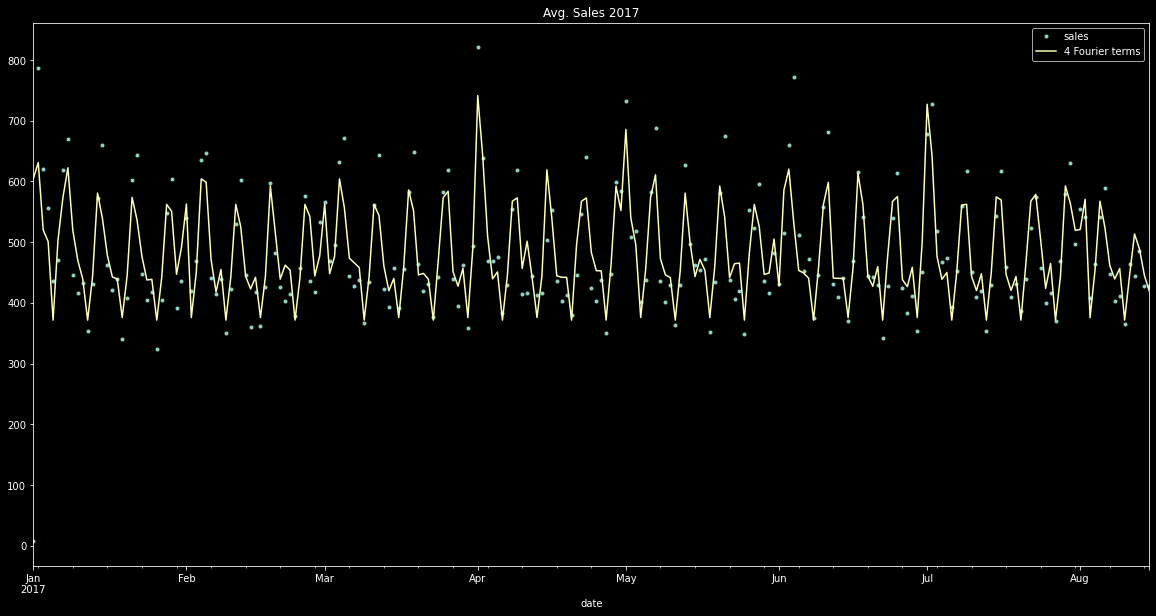

In [86]:
from sklearn.ensemble import RandomForestRegressor
average_sales = df_store_sales.groupby('date').mean().sales
average_sales17 = (df_store_sales.groupby('date').mean().sales.squeeze().loc['2017'])
y = average_sales_2017.copy()

fourier_terms = CalendarFourier(freq='M', order = 4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order = 1,
    seasonal = True,
    additional_terms=[fourier_terms],
    drop = True,
)

X = dp.in_sample()
forest= RandomForestRegressor(n_estimators=10, max_leaf_nodes=16, n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
forest.fit(X_train,y_train)

y1_pred = pd.Series(forest.predict(X), index = X.index)

ax=y.plot(style='.', figsize=(20,10), title="Avg. Sales 2017")
ax=y1_pred.plot(ax=ax, label='4 Fourier terms')
ax.legend();

In [87]:
Xpred = dp.out_of_sample(steps=16)
ypred = pd.Series(forest.predict(Xpred), index=Xpred.index)

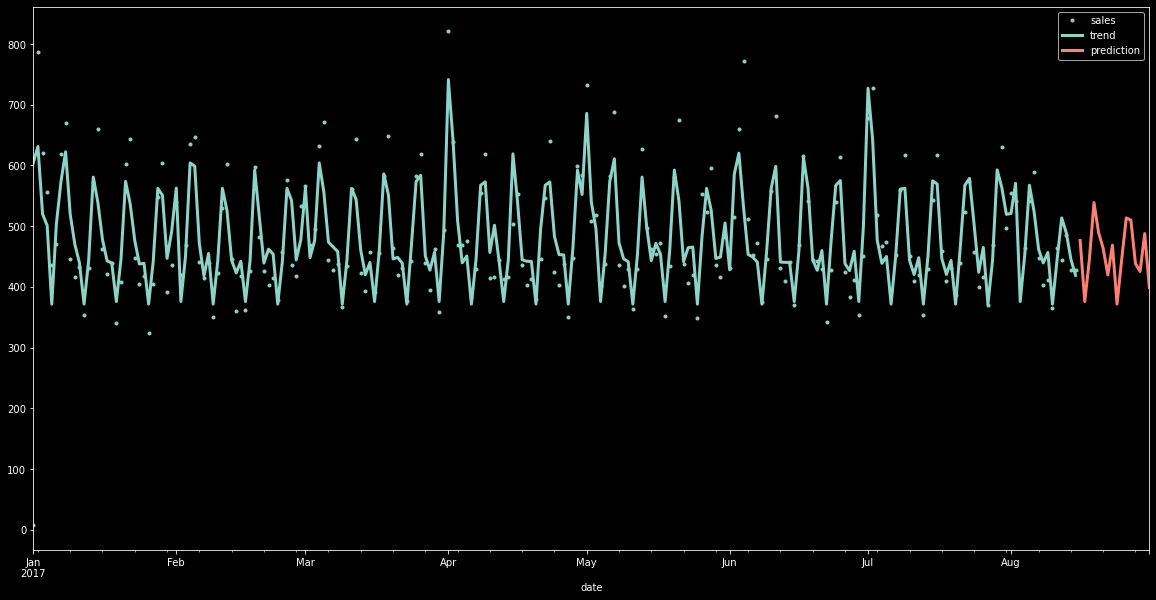

In [88]:
ax=average_sales17.plot(style='.', figsize=(20,10))
ax=y1_pred.plot(ax=ax, linewidth=3, label='trend', color='C0')
ax=ypred.plot(ax=ax, linewidth=3, label='prediction', 
                   color='C3')
ax.legend();

In [93]:
scores = cross_val_score(forest, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.27066977 0.7808187  0.57246083 0.24251609 0.55271423]
0.48 accuracy with a standard deviation of 0.20


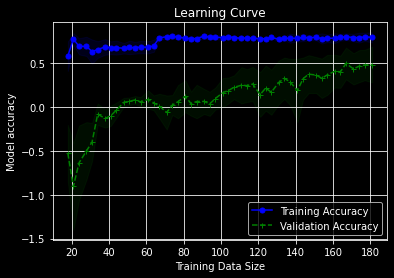

In [90]:
train_sizes, train_scores, test_scores = learning_curve(forest, X, y, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

We can see that this model has a high value of bias, meaning is underfitting. 

## **Final Model**

### GradientBoostingRegressor

Este algoritmo utiliza una serie de arboles de decisión en serie.  Los cuales inicialmente no tienen un buen desepeño, pero al hacer que la salida y el error del uno sea entradas del siguiente creamos un efecto de boosting. 

- Gradientes

- Funciones de perdida

In [46]:
#load train again
df_store_sales = pd.read_csv('train.csv',
                             usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                             dtype = {
                                    'store_nbr': 'category',
                                    'family': 'category',
                                    'sales': 'float32',
                                    'onpromotion': 'uint32',
                                },
                                parse_dates=['date'],
                                infer_datetime_format=True)
df_store_sales['date'] = df_store_sales.date.dt.to_period('D')
df_store_sales = df_store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
df_store_sales = shuffle(df_store_sales)

### Review the sales data again

In [47]:
average_sales = df_store_sales.groupby('date').mean().sales
average_sales

date
2013-01-01     1.4094
2013-01-02   278.3908
2013-01-03   202.8402
2013-01-04   198.9111
2013-01-05   267.8732
               ...   
2017-08-11   463.7339
2017-08-12   444.7983
2017-08-13   485.7686
2017-08-14   427.0047
2017-08-15   427.9809
Freq: D, Name: sales, Length: 1684, dtype: float32

Text(0, 0.5, 'Sales')

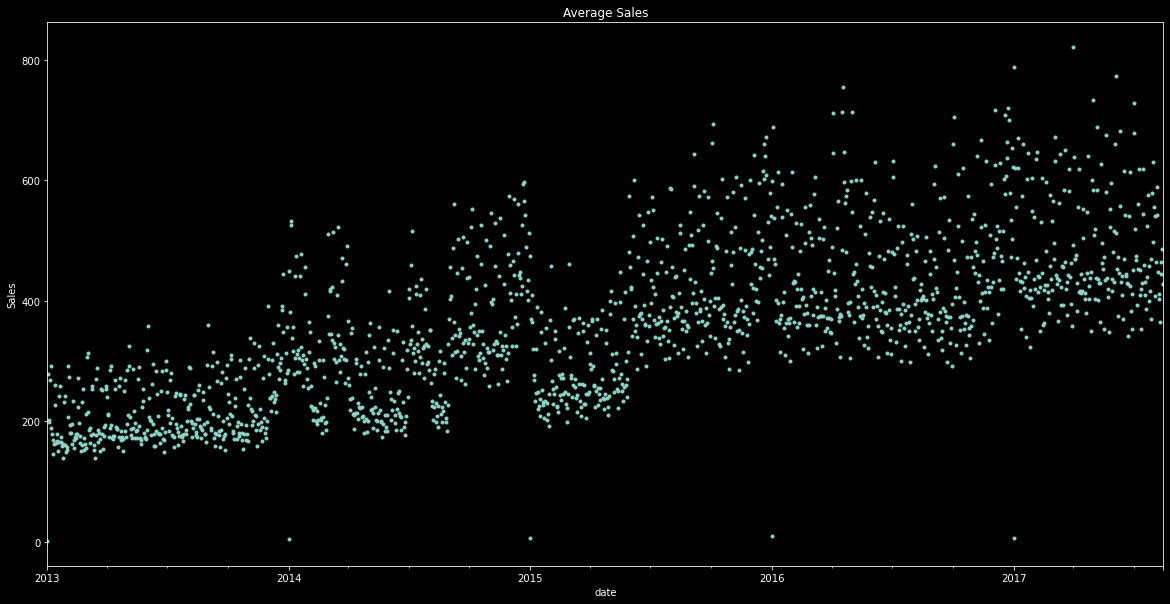

In [48]:
average_sales.plot(style='.', figsize=(20,10))
plt.title("Average Sales")
plt.ylabel("Sales")

We will only use data of the year 2017 to avoid the model to be affected by the consequences of the earthquake that took place in 2016. 

In [49]:
average_sales17 = (df_store_sales.groupby('date').mean().sales.squeeze().loc['2016-07-01':'2017'])

In [50]:
average_sales17

date
2016-07-01   480.9358
2016-07-02   605.2105
2016-07-03   632.2748
2016-07-04   477.4925
2016-07-05   408.5362
               ...   
2017-08-11   463.7339
2017-08-12   444.7983
2017-08-13   485.7686
2017-08-14   427.0047
2017-08-15   427.9809
Freq: D, Name: sales, Length: 410, dtype: float32

In [51]:
average_sales17.describe()

count   410.0000
mean    466.5392
std     102.0022
min       6.7803
25%     400.6189
50%     441.2341
75%     523.3322
max     821.0348
Name: sales, dtype: float64

Text(0, 0.5, 'Sales')

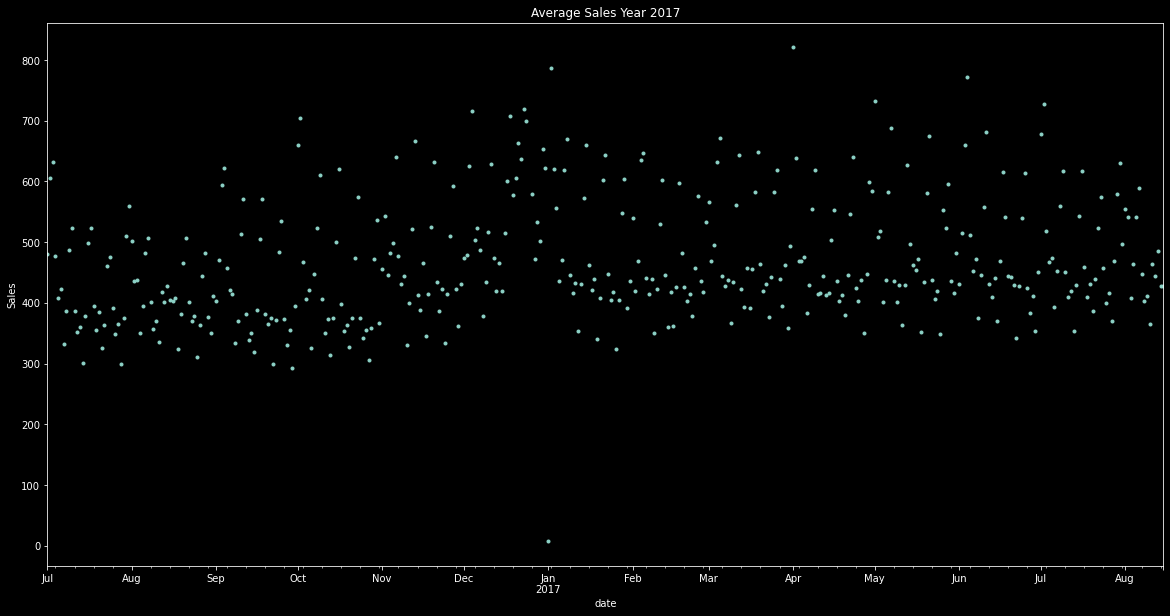

In [52]:
average_sales17.plot(style='.',figsize=(20,10))
plt.title("Average Sales Year 2017")
plt.ylabel("Sales")

### Get Y and X for traing the model

In [53]:
y = average_sales17.copy()

In [54]:
y.index

PeriodIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
             '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
             '2016-07-09', '2016-07-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=410, freq='D')

In [55]:
fourier_terms = CalendarFourier(freq='M', order=2)
fourier_terms

Fourier(freq=M, order=2) at 0x19ab4826280

In [56]:
dp = DeterministicProcess(
   index = y.index,
   constant = True,
   order = 2,
   seasonal = True,
   additional_terms=[fourier_terms],
   drop = True
   )

In [57]:
X = dp.in_sample()


In [58]:
X

const    trend  trend_squared  s(2,7)  s(3,7)  s(4,7)  s(5,7)  \
date                                                                        
2016-07-01 1.0000   1.0000         1.0000  0.0000  0.0000  0.0000  0.0000   
2016-07-02 1.0000   2.0000         4.0000  1.0000  0.0000  0.0000  0.0000   
2016-07-03 1.0000   3.0000         9.0000  0.0000  1.0000  0.0000  0.0000   
2016-07-04 1.0000   4.0000        16.0000  0.0000  0.0000  1.0000  0.0000   
2016-07-05 1.0000   5.0000        25.0000  0.0000  0.0000  0.0000  1.0000   
...           ...      ...            ...     ...     ...     ...     ...   
2017-08-11 1.0000 406.0000    164836.0000  0.0000  0.0000  0.0000  0.0000   
2017-08-12 1.0000 407.0000    165649.0000  0.0000  0.0000  0.0000  0.0000   
2017-08-13 1.0000 408.0000    166464.0000  1.0000  0.0000  0.0000  0.0000   
2017-08-14 1.0000 409.0000    167281.0000  0.0000  1.0000  0.0000  0.0000   
2017-08-15 1.0000 410.0000    168100.0000  0.0000  0.0000  1.0000  0.0000   

            s(6,7)  s(7,7)  sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  \
date                                                                      
2016-07-01  0.0000  0.0000         0.0000         1.0000         0.0000   
2016-07-02  0.0000  0.0000         0.2013         0.9795         0.3944   
2016-07-03  0.0000  0.0000         0.3944         0.9190         0.7248   
2016-07-04  0.0000  0.0000         0.5713         0.8208         0.9378   
2016-07-05  0.0000  0.0000         0.7248         0.6890         0.9987   
...            ...     ...            ...            ...            ...   
2017-08-11  0.0000  1.0000         0.8978        -0.4404        -0.7908   
2017-08-12  0.0000  0.0000         0.7908        -0.6121        -0.9681   
2017-08-13  0.0000  0.0000         0.6514        -0.7588        -0.9885   
2017-08-14  0.0000  0.0000         0.4853        -0.8743        -0.8486   
2017-08-15  0.0000  0.0000         0.2994        -0.9541        -0.5713   

            cos(2,freq=M)  
date                       
2016-07-01         1.0000  
2016-07-02         0.9190  
2016-07-03         0.6890  
2016-07-04         0.3473  
2016-07-05        -0.0506  
...                   ...  
2017-08-11        -0.6121  
2017-08-12        -0.2507  
2017-08-13         0.1514  
2017-08-14         0.5290  
2017-08-15         0.8208  

[410 rows x 13 columns]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.25 x 0.8 = 0.2

### Create and train the model (Refinamiento)

Ajuste de hiper parámetros



In [60]:
model1 = GradientBoostingRegressor(random_state=0,learning_rate=0.1)

In [61]:
model1.fit(X,y)

GradientBoostingRegressor(random_state=0)

### Test Model

In [62]:
pred1_y = pd.Series(model1.predict(X), index=X.index, 
                    name='4 Fourier Terms')

In [63]:
pred1_y

date
2016-07-01   493.5793
2016-07-02   565.1764
2016-07-03   605.9556
2016-07-04   472.3444
2016-07-05   406.0355
               ...   
2017-08-11   452.1746
2017-08-12   469.3086
2017-08-13   526.7609
2017-08-14   430.0074
2017-08-15   411.5582
Freq: D, Name: 4 Fourier Terms, Length: 410, dtype: float64

In [64]:
model1.score(X, y)

0.8883504063508763

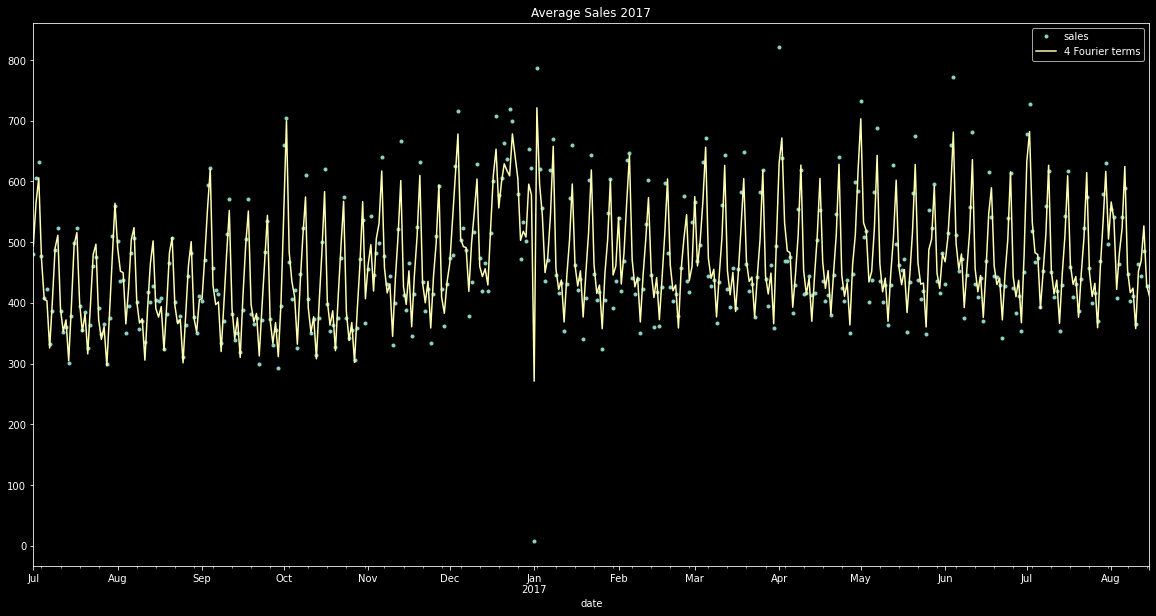

In [65]:
ax=y.plot(style='.', figsize=(20,10), title="Average Sales 2017")
ax=pred1_y.plot(ax=ax, label='4 Fourier terms')
ax.legend()

### Analysis

In [66]:
from sklearn.model_selection import cross_val_score

In [67]:
scores = cross_val_score(model1, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.76365436 0.34420796 0.01481274 0.68383298 0.72916948]
0.51 accuracy with a standard deviation of 0.29


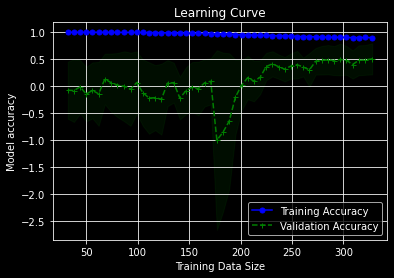

In [70]:
train_sizes, train_scores, test_scores = learning_curve(model1, X, y, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

We can see that the model is great at predicing the training data, but not so much the validation data. This means that the model is overfitting to the training data. Models like this ones are prone to overfitting because of the number of times the process is repeated. To fix this problem, we have to apply a process of regularization to the data.  